## Accessing NASADEM data on Azure (NetCDF)

[NASADEM](https://earthdata.nasa.gov/esds/competitive-programs/measures/nasadem) provides global topographic data at 1 arc-second (~30m) horizontal resolution, derived primarily from data captured via the [Shuttle Radar Topography Mission](https://www2.jpl.nasa.gov/srtm/) (SRTM).

NASADEM is hosted on Azure in both NetCDF and cloud-optimized GeoTIFF formats; this notebook demonstrates access to the NetCDF-formatted data.

This notebook demonstrates access to NASADEM data from blob storage on Azure, including (1) finding the NASADEM tile corresponding to a lat/lon coordinate and (2) opening and plotting the tile using [xarray](http://xarray.pydata.org/).

This dataset is stored in the West Europe Azure region, so this notebook will run most efficiently on Azure compute located in the same region.  If you are using this data for environmental science applications, consider applying for an [AI for Earth grant](http://aka.ms/ai4egrants) to support your compute requirements.

This dataset is documented at [aka.ms/ai4edata-nasadem](http://aka.ms/ai4edata-nasa).

### Imports and environment

In [1]:
import os
import tempfile
import numpy as np
import shutil
import urllib
import math
import matplotlib.pyplot as plt

import fsspec
import xarray as xr

# Not used directly, but needs to be installed to read NetCDF files with xarray
import h5netcdf

nasadem_account_name = 'nasademeuwest'
nasadem_container_name = 'nasadem-nc'
nasadem_account_url = 'https://' + nasadem_account_name + '.blob.core.windows.net'
nasadem_blob_root = nasadem_account_url + '/' + nasadem_container_name + '/v001/'

# A full list of files is available at:
#
# https://nasademeuwest.blob.core.windows.net/nasadem-nc/v001/index/nasadem_file_list.txt
nasadem_file_index_url = nasadem_blob_root + 'index/nasadem_file_list.txt'

nasadem_content_extension = '.nc'
nasadem_file_prefix = 'NASADEM_NC_'

# This will contain a list of all available .nc files
nasadem_file_list = None
                                   
temp_dir = os.path.join(tempfile.gettempdir(),'nasadem')
os.makedirs(temp_dir,exist_ok=True)

### Functions

In [2]:
def download_url(url,destination_filename=None):
    """
    Download a URL to a temporary file
    """
    
    if destination_filename is None:
        url_as_filename = url.replace('://', '_').replace('/', '_')    
        destination_filename = os.path.join(temp_dir,url_as_filename)    
    urllib.request.urlretrieve(url, destination_filename)  
    return destination_filename


def lat_lon_to_nasadem_tile(lat,lon):
    """
    Get the NASADEM file name for a specified latitude and longitude
    """
    
    # A tile name looks like:
    #
    # NASADEM_NUMNC_n00e016.nc
    #
    # The translation from lat/lon to that string is represented nicely at:
    #
    # https://dwtkns.com/srtm30m/

    # Force download of the file list
    get_nasadem_file_list()
        
    ns_token = 'n' if lat >=0 else 's'
    ew_token = 'e' if lon >=0 else 'w'
    
    lat_index = abs(math.floor(lat))
    lon_index = abs(math.floor(lon))
    
    lat_string = ns_token + '{:02d}'.format(lat_index)
    lon_string = ew_token + '{:03d}'.format(lon_index)
    
    filename = nasadem_file_prefix + lat_string + lon_string + \
        nasadem_content_extension

    if filename not in nasadem_file_list:
        print('Lat/lon {},{} not available'.format(lat,lon))
        filename = None
    
    return filename


def get_nasadem_file_list():
    """
    Retrieve the full list of NASADEM tiles
    """
    
    global nasadem_file_list
    if nasadem_file_list is None:
        nasadem_file = download_url(nasadem_file_index_url)
        with open(nasadem_file) as f:
            nasadem_file_list = f.readlines()
            nasadem_file_list = [f.strip() for f in nasadem_file_list]
            nasadem_file_list = [f for f in nasadem_file_list if \
                                 f.endswith(nasadem_content_extension)]
    return nasadem_file_list

### Load a NASADEM tile for a known lat/lon

In [3]:
# Interesting places for looking at SRTM data
everest = [27.9881,86.9250]
seattle = [47.6062,-122.3321]
grand_canyon = [36.101690, -112.107676]
mount_fuji = [35.3606, 138.7274]
mont_blanc = [45.832778, 6.865000]
invalid = [-15.1,41]

tile_of_interest = mount_fuji

tile_name = lat_lon_to_nasadem_tile(tile_of_interest[0],tile_of_interest[1])
url = nasadem_blob_root + tile_name

with fsspec.open(url) as f:
    ds = xr.open_dataset(f)
print(ds)

C:\users\dan\Anaconda3\lib\site-packages\h5netcdf\core.py:765: FutureWarning: String decoding changed with h5py >= 3.0. Currently backwards compatibility with h5py < 3.0 is kept by decoding vlen strings per default. This will change in future versions for consistency with h5py >= 3.0. Setting 'decode_vlen_strings=True' forces string decoding.
  warnings.warn(msg, FutureWarning, stacklevel=0)


<xarray.Dataset>
Dimensions:      (lat: 3601, lon: 3601)
Coordinates:
  * lat          (lat) float64 36.0 36.0 36.0 36.0 36.0 ... 35.0 35.0 35.0 35.0
  * lon          (lon) float64 138.0 138.0 138.0 138.0 ... 139.0 139.0 139.0
Data variables:
    NASADEM_HGT  (lat, lon) float32 ...
    crs          |S1 ...
Attributes:
    history:                   Sat Aug 25 23:21:28 2018: /usr/bin/ncpdq -O -a...
    nco_openmp_thread_number:  [1]
    GDAL_AREA_OR_POINT:        Point
    Conventions:               CF-1.5
    GDAL:                      GDAL 2.2.0dev, released 2016/99/99
    NCO:                       4.3.7


### Plot the tile

Height ranges from -18.0 meters to 3756.0 meters


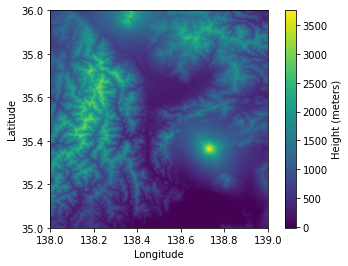

In [5]:
heights = ds['NASADEM_HGT'][:].values
lons = ds['lon'][:].values
lats = ds['lat'][:].values

min_height = np.min(heights)
max_height = np.max(heights)
height_units = ds['NASADEM_HGT'].units

print('Height ranges from {} {} to {} {}'.format(min_height,height_units,
      max_height,height_units))

extent = [np.min(lons), np.max(lons), np.min(lats), np.max(lats)]
plt.imshow(heights,extent=extent)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
cb = plt.colorbar()
cb.set_label('Height ({})'.format(height_units))

### Clean up temporary files

In [6]:
shutil.rmtree(temp_dir)